In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from keras.callbacks import EarlyStopping

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve


from keras.models import Sequential
import tensorflow as tf
from keras import optimizers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard,CSVLogger
from keras.models import load_model

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)




In [3]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [4]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/input_data.csv', sep='\t', encoding='utf-8', index_col=0)


In [5]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(229716, 2) (229716,)


# Temporalize data

In [6]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y


In [7]:
# Temporalize the data

lookback = 20
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)



# Split into Test, valid and train

In [8]:
#Split into Test, valid and train

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

## Separate negatives and positives values

In [9]:
X_train_y0 = X_train[y_train==0.]
X_train_y1 = X_train[y_train==1.]

X_valid_y0 = X_valid[y_valid==0.]
X_valid_y1 = X_valid[y_valid==1.]

In [10]:
# Reshape the arrays

X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

In [11]:
y_train.shape

(147004,)

In [12]:
## To Categorical Data

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# print(y_valid.shape, y_test.shape, y_train.shape)

In [13]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
print(n_timesteps,n_features,n_outputs)

20 2 1


# Stardarization

In [14]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [15]:
# Initialize a scaler using the training data.
# scaler = StandardScaler().fit(flatten(X_train))

In [16]:
# Standarize the input

# X_train_y0_scaled = scale(X_train_y0, scaler)
# X_valid_y0_scaled = scale(X_valid_y0, scaler)
# X_test_scaled = scale(X_test, scaler)

### Test Standarization

In [17]:
# a = flatten(X_train_y0_scaled)
# print('colwise mean', np.mean(a,axis=0).round(2))
# print('colwise variance', np.var(a, axis=0))



# Model training

Training models (Use it)


In [18]:
# # Parameters

# verbose, epochs, batch_size = 1, 50, 64

# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(n_timesteps,n_features), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(n_features)))
# model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

# # model = Sequential()
# # model.add(LSTM(50, input_shape=(n_timesteps,n_features)))
# # model.add(Dropout(0.5))
# # model.add(Dense(50, activation='relu'))
# # #     model.add(Dense(n_outputs, activation='softmax'))
# # model.add(Dense(n_features, activation='softmax'))
# # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# cp = ModelCheckpoint(filepath="/home/francovm/Projects/SSE/models/Vanilla/Vanilla-anomaly_LSTM_SSE_20window.h5",
#                                save_best_only=True,
#                                verbose=0)

# tb = TensorBoard(log_dir='/home/francovm/Projects/SSE/models/Vanilla/Tensorboard/Vanilla-anomaly_LSTM_SSE_20window',
#                  histogram_freq=0,
#                  write_graph=True,write_images=True)

# csv_logger = CSVLogger('/home/francovm/Projects/SSE/data/Visualization/Data/Vanilla-anomaly_LSTM_SSE_20window.csv', append=True, separator=';')

# #set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=8)

# # fit network
# history = model.fit(X_train_y0, X_train_y0, epochs=epochs, batch_size=batch_size,validation_data=(X_valid_y0, X_valid_y0), 
#                     verbose=verbose,callbacks=[early_stopping_monitor,csv_logger,cp,tb])




In [19]:
# # list all data in history
# print(history.history.keys())

# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')

# # Get current size
# fig_size = plt.rcParams["figure.figsize"]
# #  Set figure width to 18 and height to 4
# fig_size[0] = 18
# fig_size[1] = 4
# plt.rcParams["figure.figsize"] = fig_size

# plt.savefig('/home/francovm/Projects/SSE/data/Visualization/Vanilla-anomaly_LSTM_SSE_20window.png')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
#  # Get current size
# fig_size = plt.rcParams["figure.figsize"]

# # Set figure width to 18 and height to 4
# fig_size[0] = 18
# fig_size[1] = 4
# plt.rcParams["figure.figsize"] = fig_size

# plt.savefig('/home/francovm/Projects/SSE/data/Visualization/Vanilla-anomaly_LSTM_SSE_20window.png')
# plt.show()

# Save Model

In [38]:
# save model and architecture to single file
# model.save("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days-shifted.h5")
# load model
model = load_model("/home/francovm/Projects/SSE/models/Vanilla/Vanilla-anomaly_LSTM_SSE_20window.h5")
# summarize model.
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 20, 128)           67072     
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 64)            49408     
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 64)            33024     
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 128)           98816     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 2)             258       
Total params: 248,578
Trainable params: 248,578
Non-trainable params: 0
_________________________________________________________________


# Sanity check

Doing a sanity check by validating the reconstruction error on the train data. Here we will reconstruct the entire train data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should be smaller than 1.

**Caution**: do not use this result for model evaluation. It may result into overfitting issues.

In [39]:
train_x_predictions = model.predict(X_train)

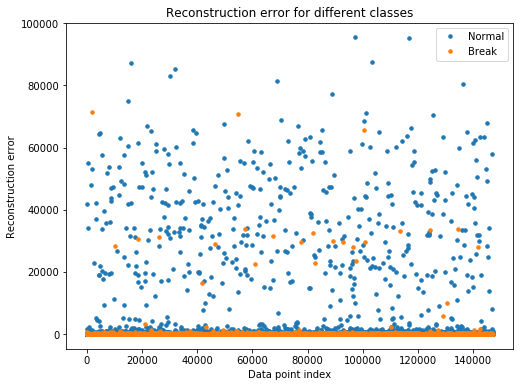

In [40]:
# train_x_predictions = lstm_autoencoder.predict(X_train)

mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

# error_df = error_df.reset_index()
groups = error_df.groupby('True_class')

fig, ax = plt.subplots()

# print(np.reshape(group.index,140681,1), group.Reconstruction_error)
for name, group in groups:
    ax.plot(group.Reconstruction_error, marker='o', ms=3.5, linestyle='',label= "Break" if name == 1. else "Normal")

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()



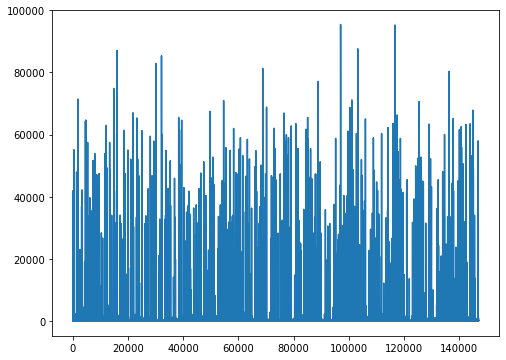

In [41]:
plt.plot(mse)

# Predictions using the Autoencoder

In [24]:
valid_x_predictions = model.predict(X_valid)

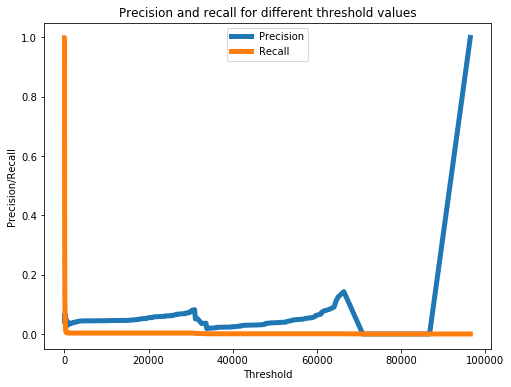

In [25]:
# valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Threshold 

(0.0, 10)

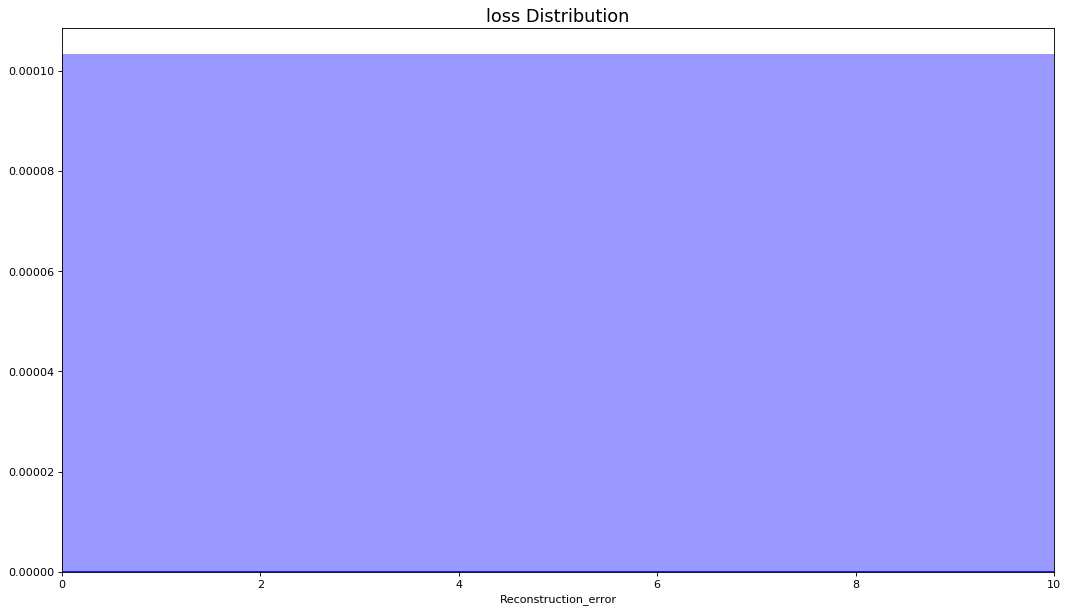

In [26]:
plt.figure(figsize=(16,9),dpi=80)
plt.title('loss Distribution', fontsize=16)
sns.distplot(error_df['Reconstruction_error'],bins=10,kde=True,color='blue');
plt.xlim([0.0,10])

# loop

In [27]:
# threshold=0
# f1=0
# recall=0
# accuracy=0
# while (recall < 0.5 or accuracy < 0.6):
#     print ('**************************')
#     print (threshold)
# #     threshold += .0005
#     threshold += 1000
#     y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
#     conf_matrix = confusion_matrix(error_df.True_class, y_pred)
#     tn, fp, fn, tp = conf_matrix.ravel()
#     precision = 1. * tp / (tp + fp)
#     recall = 1. * tp / (tp + fn)
#     f1 = (2 * recall * precision) / (recall + precision)
# # print ('**************************')
# # print (threshold)
#     print ('TP:' + str(tp))
#     print ('FP:' + str(fp))
#     print ('TN:' + str(tn))
#     print ('FN:' + str(fn))
#     accuracy = 1. * (tp + tn) / (tp + tn + fp + fn)
#     print ('Accuracy:' + str(accuracy))
#     print ('Precision:' + str(precision))
#     print ('Recall:' + str(recall))
#     print ('F1:' + str(f1))


In [42]:
test_x_predictions = model.predict(X_test)

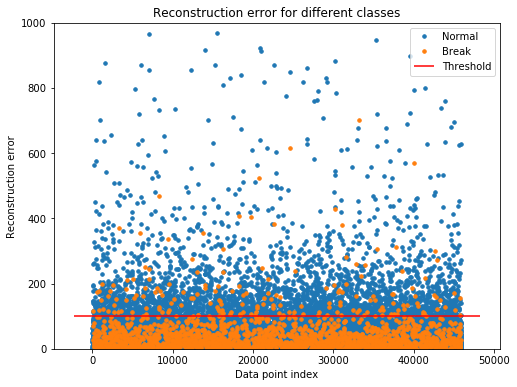

In [59]:
# test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 100 # Definir!
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot( group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.ylim(0,1000)
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [60]:
error_df.describe()

,Reconstruction_error,True_class
count,45939.000000,45939.000000
mean,154.774115,0.041838
std,2334.084694,0.200221
min,0.000302,0.000000
25%,8.094076,0.000000
50%,19.292945,0.000000
75%,41.932585,0.000000
max,87934.852304,1.000000


In [61]:

pred_y = [1. if e > threshold_fixed else 0. for e in error_df.Reconstruction_error.values]

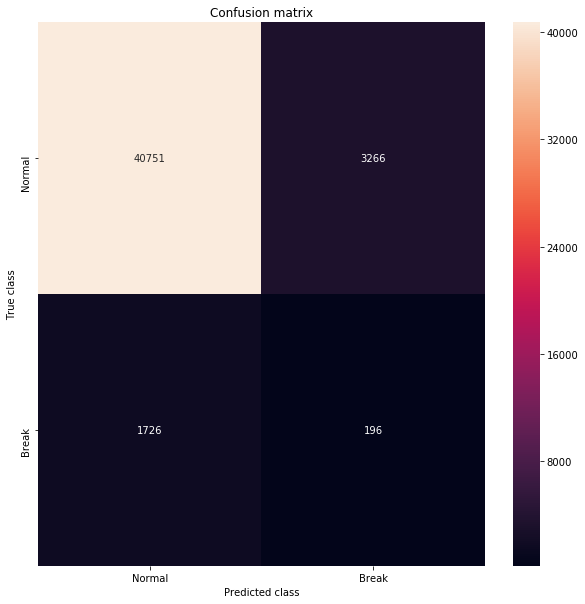

In [62]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(10, 10))
ax = sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
ax.set_ylim(2, 0)
plt.show()




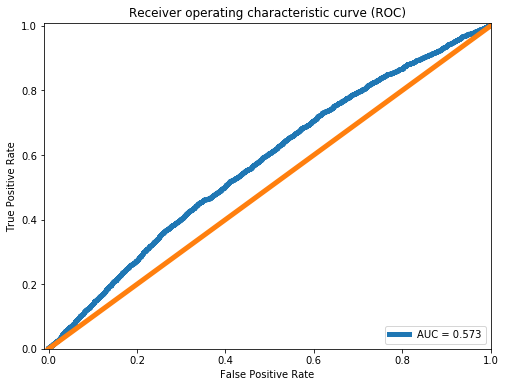

In [63]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()